In [6]:
!CXXFLAGS+=-stdlib=libc++ maturin develop --release
quit()

🔗 Found pyo3 bindings
🐍 Found CPython 3.11 at /Users/josh/josh/projects/tech/riversim/.venv/bin/python
💻 Using `MACOSX_DEPLOYMENT_TARGET=10.7` for x86_64-apple-darwin by default
   Compiling pyo3-build-config v0.18.3
   Compiling pyo3-ffi v0.18.3=======>  ] 208/217: pyo3-build-config           
   Compiling pyo3 v0.18.3
   Compiling numpy v0.18.0========> ] 214/217: pyo3                           
   Compiling riversim v0.1.0 (/Users/josh/josh/projects/tech/riversim)        
    Finished release [optimized] target(s) in 17.01sversim                    
📦 Built wheel for CPython 3.11 to /var/folders/w9/c8qym84j2pg4fjvx_bzr84bc0000gn/T/.tmpKhFElG/riversim-0.1.0-cp311-cp311-macosx_10_7_x86_64.whl
🛠 Installed riversim-0.1.0


In [1]:
import importlib

from joshpyutil import mpl
import tqdm

import riversim
riversim = importlib.reload(riversim)

example = 'advection_1d'
v_max = 0.03
example = 'singularity_1d'
v_max = 0.5

num_cells = 200
solver = getattr(riversim, example)(num_cells, 20)

courant_dt = 1 / num_cells / v_max

with mpl.autovideo(f'{example}.mp4', 2, frame_rate_hz=10) as av:
    for step in tqdm.tqdm(range(300)):
        if step % 3 == 0:
            with av.next_frame() as ap:
                # height = solver.height
                z_lattice = solver.z_lattice
                # ap.plot(solver.grid.x_axis.centers, height[:, 0, 0], label='UL')
                # ap.plot(solver.grid.x_axis.centers, height[:, 0, 1], '--', label='LR')
                ap.plot(solver.grid.x_axis.vertices, z_lattice[:, 0, -1], label='Lattice')
                ap.set(ylim=[0, 20])
                ap.legend()

                ap = ap.next()
                pressure = solver.pressure
                p_all = []
                x_all = []
                z_all = []
                for i, x in enumerate(solver.grid.x_axis.vertices):
                    p_all.extend(pressure[i, 0])
                    x_all.extend([x] * len(pressure[i, 0]))
                    z_all.extend(z_lattice[i, 0])

                ap.scatter(x_all, z_all, c=p_all, s=40, alpha=0.5, linewidth=0)
                ap.set(ylim=[0, 20])
        solver.step(courant_dt / 2)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:37<00:00,  7.95it/s]


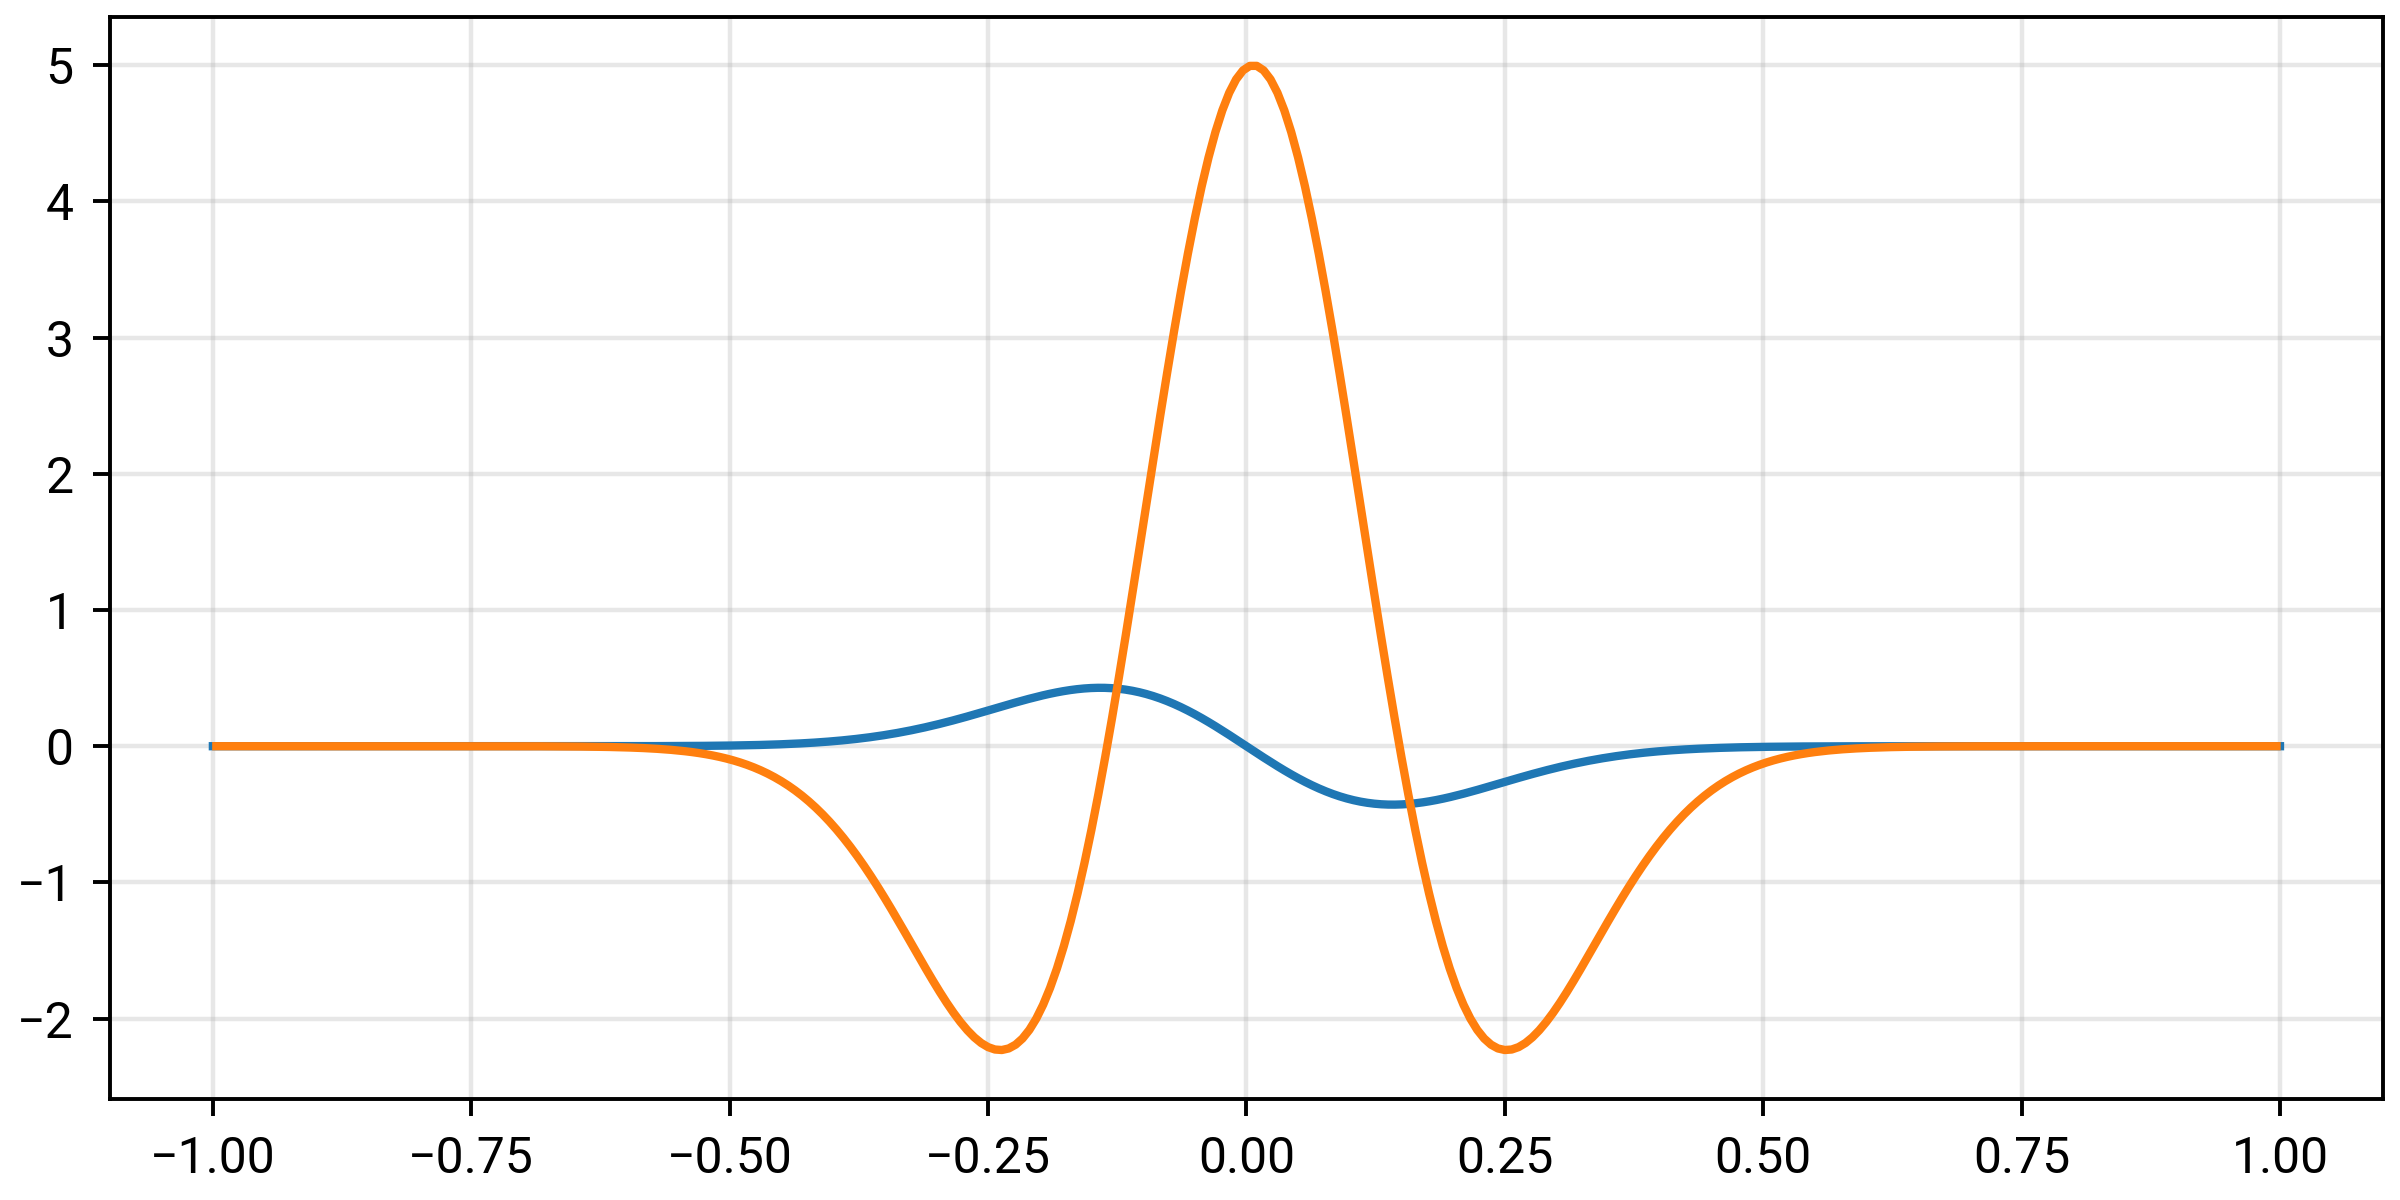

In [1]:
from joshpyutil import mpl
import numpy as np

import riversim

with mpl.autoplot() as ap:
    ap.funcplot(lambda x: -(x / 0.2) * np.exp(-(x / 0.2)**(2)), -1, 1)
    solver = riversim.singularity_1d(300, 20)
    ap.plot(solver.grid.x_axis.centers, solver.compute_height_time_deriv()[:, 0, 0])

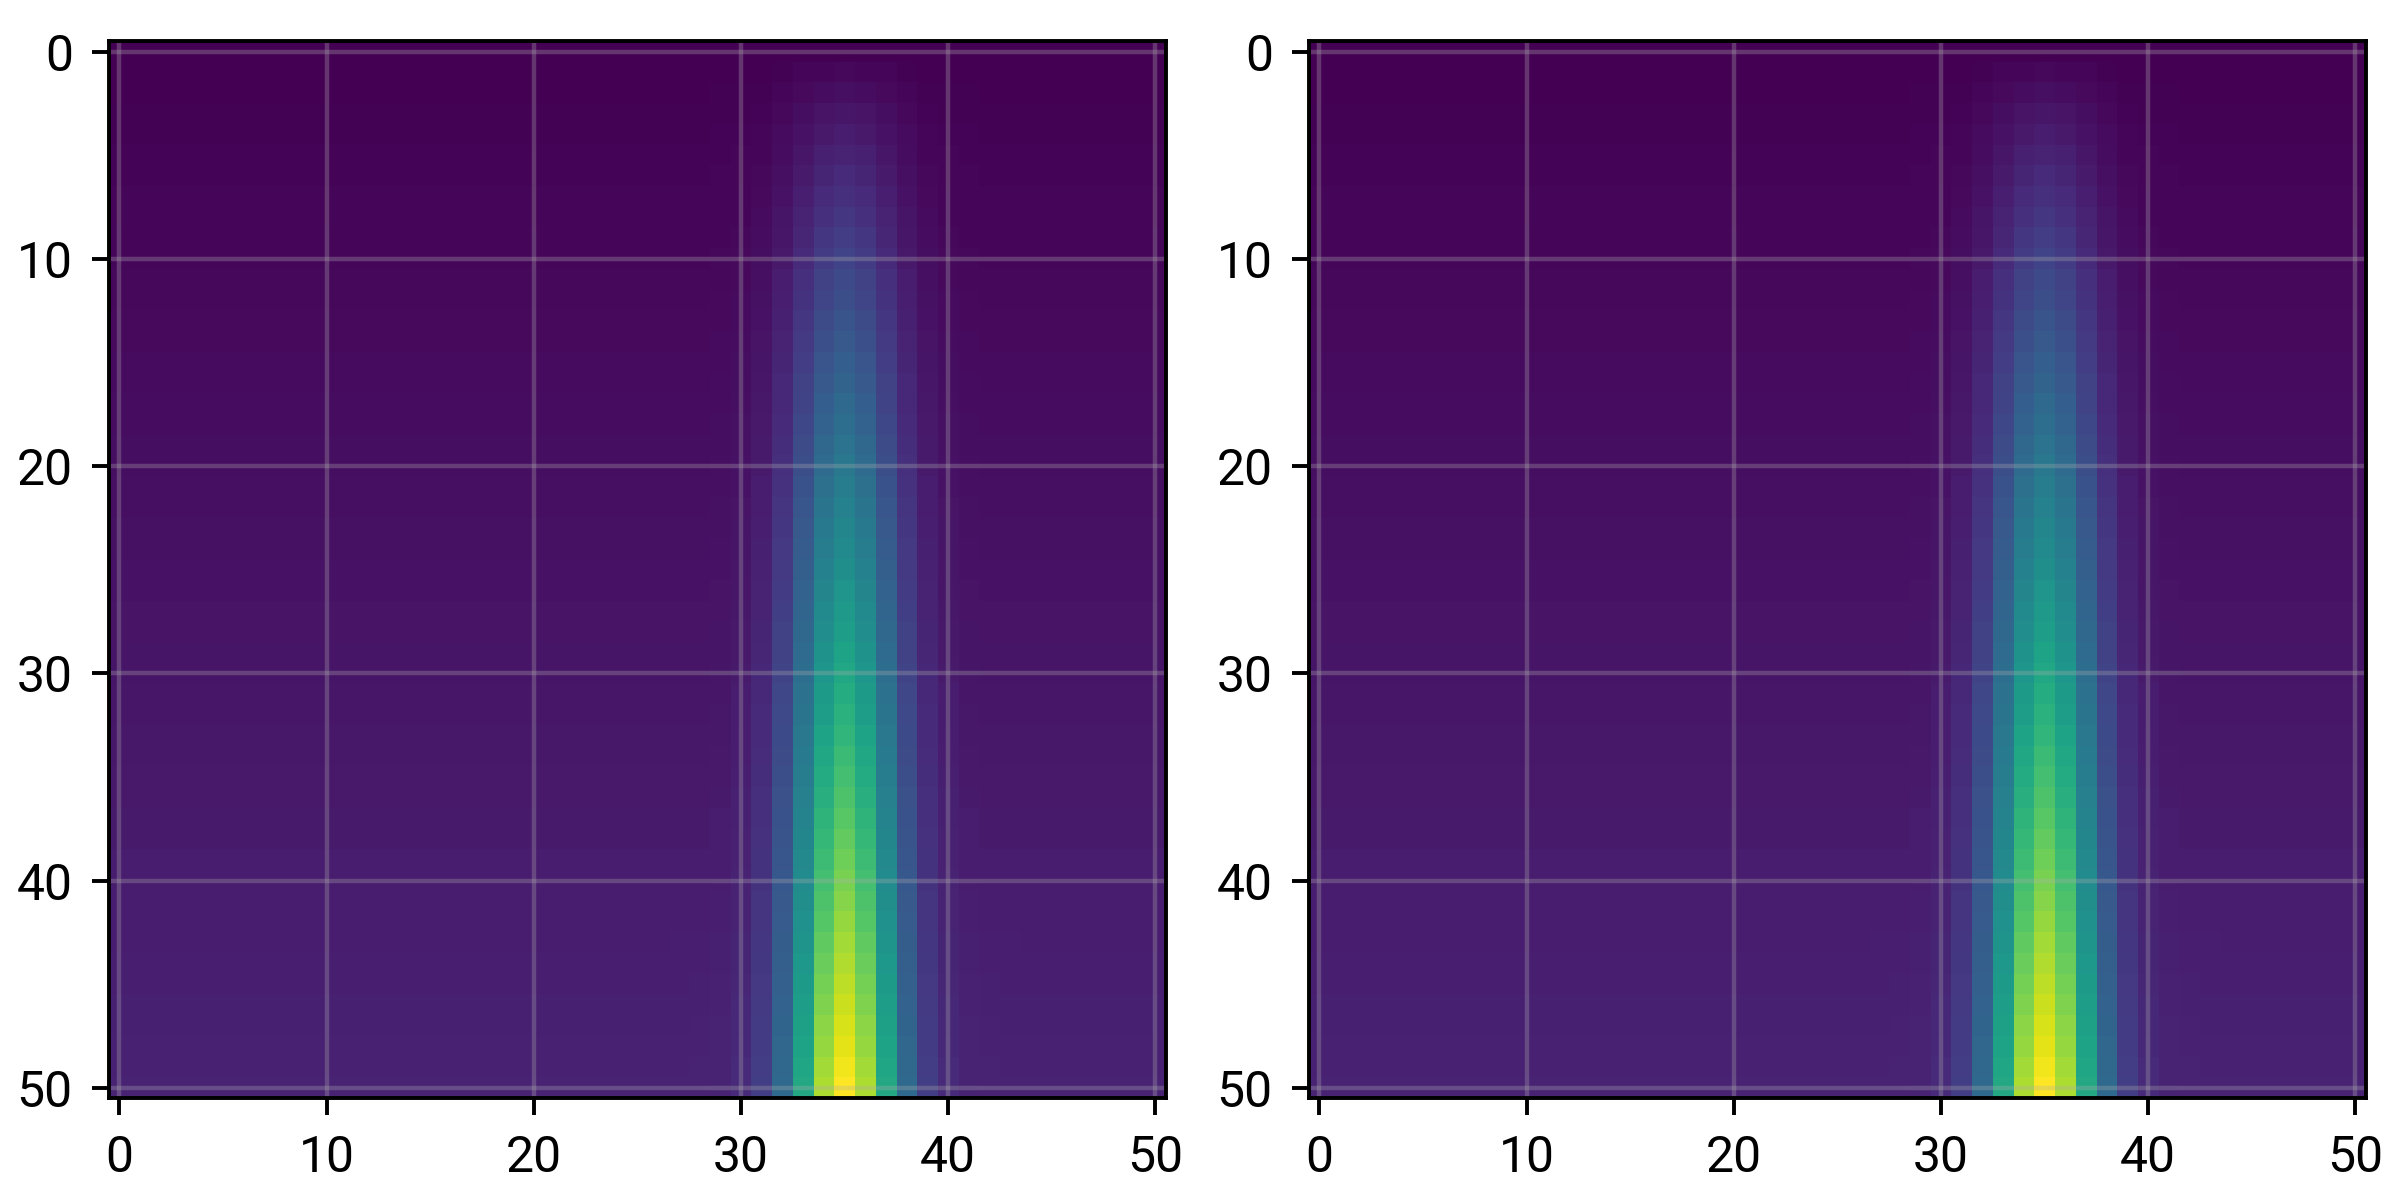

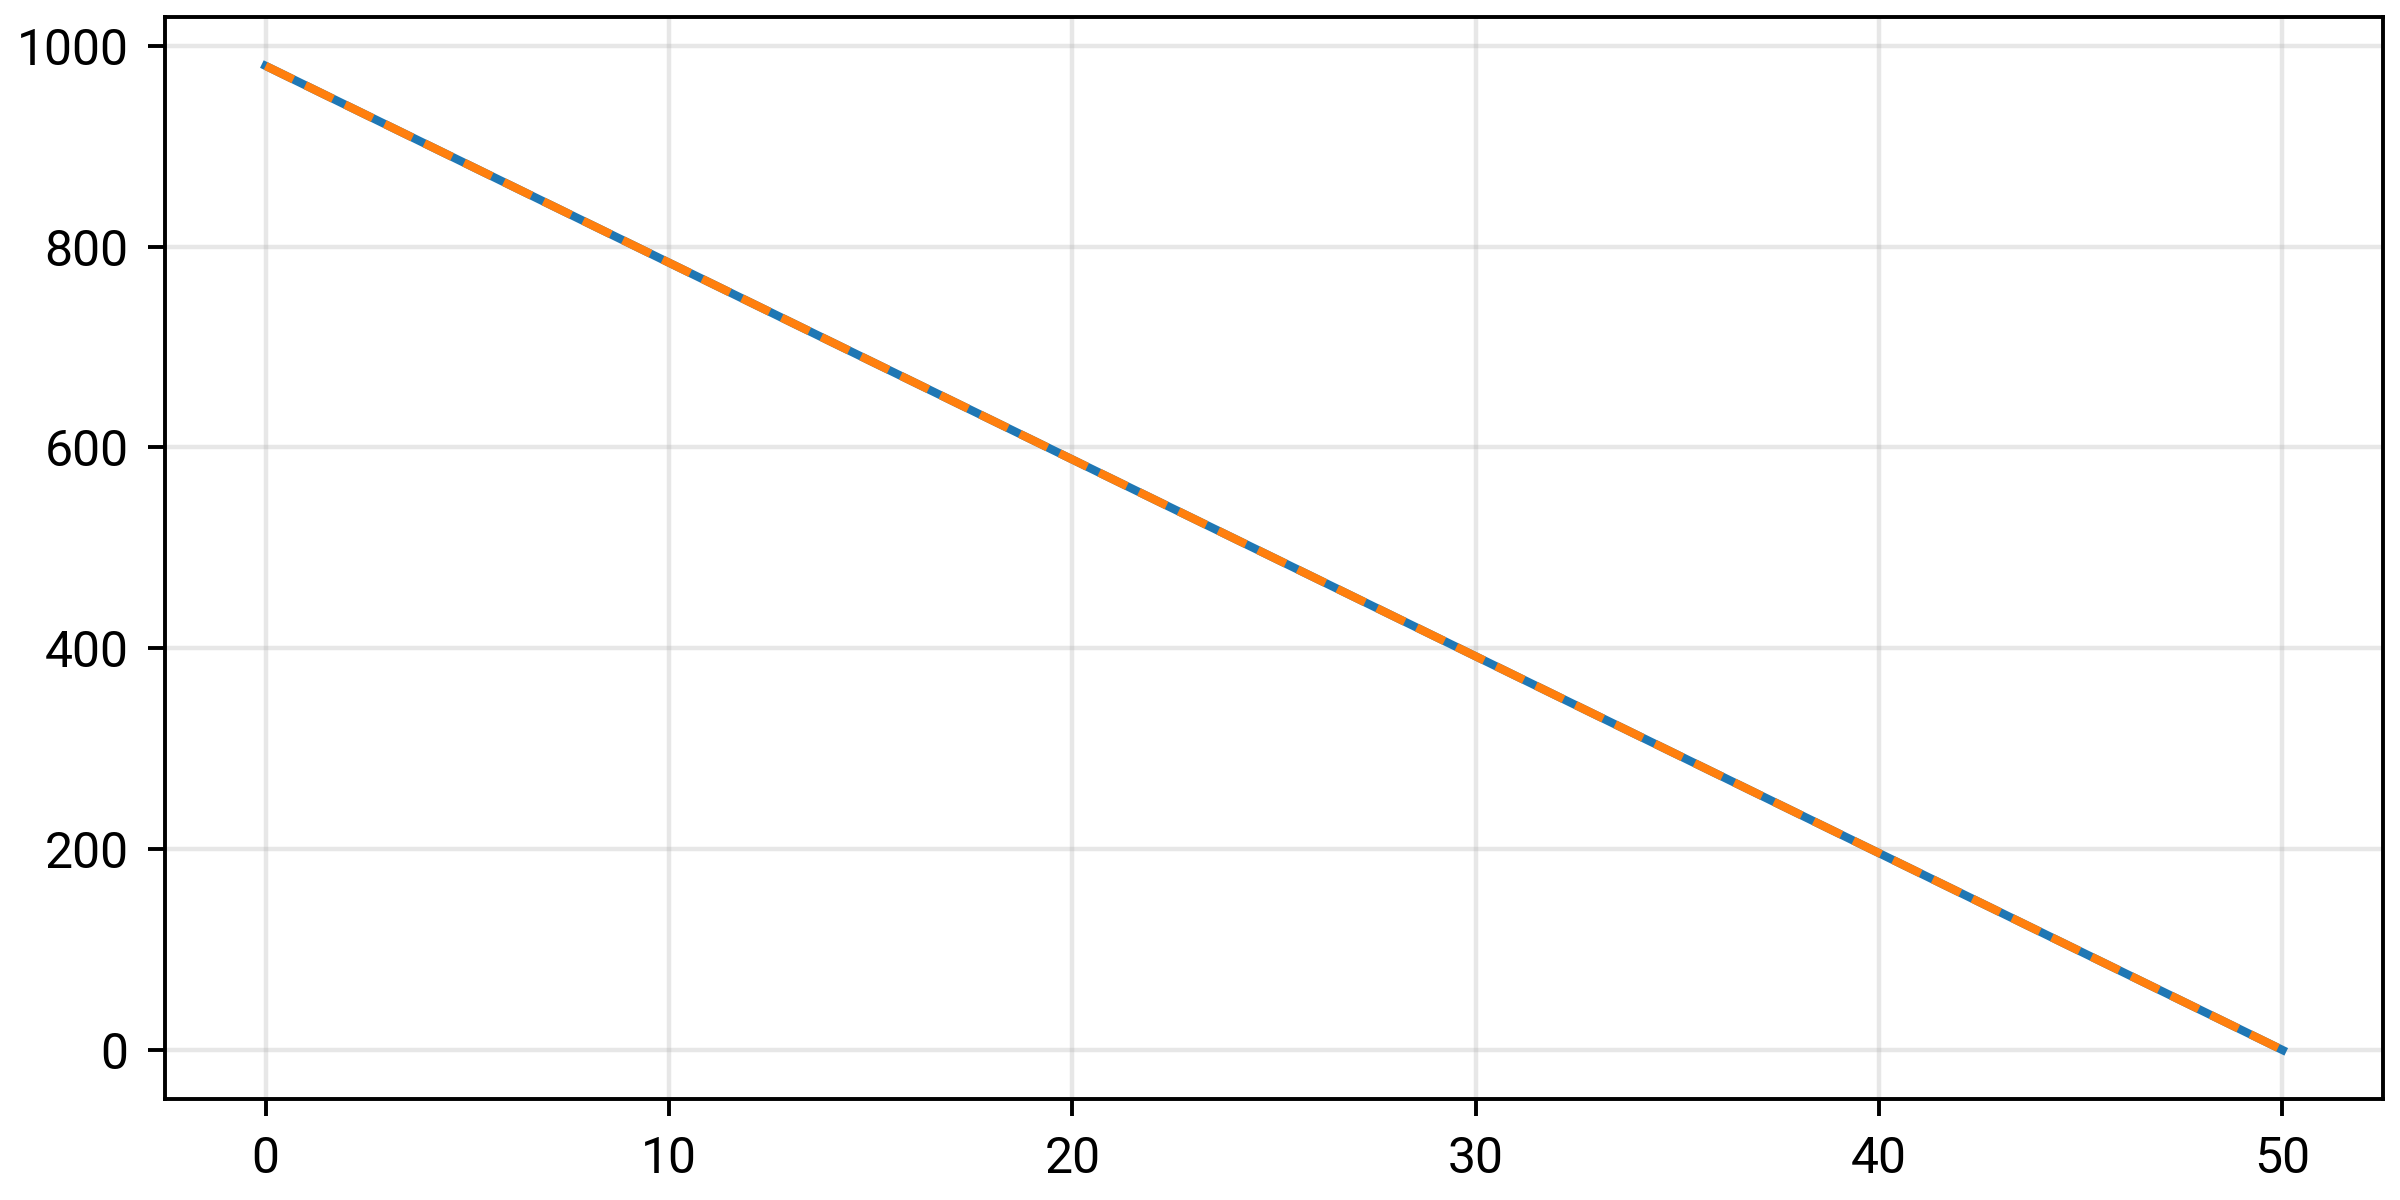

In [4]:
from joshpyutil import mpl

import riversim

solver = riversim.advection_1d(50, 50)

with mpl.autoplot(1, 2) as ap:
    _ = ap.ax.imshow(solver.pressure[:, 1, ::-1].T)

    ap = ap.next()
    _ = ap.ax.imshow(solver.pressure[:, 1, ::-1].T)

with mpl.autoplot() as ap:
    _ = ap.plot(solver.pressure[5, 0, :])
    _ = ap.plot(solver.hydrostatic_pressure[5, 0, :], '--')
    # _ = ap.plot(solver.pressure[5, 1:, 10] - solver.pressure[5, :-1, 10])
    # _ = ap.plot(solver.pressure[1:, 10, 10] - solver.pressure[:-1, 10, 10])

# (solver.pressure[4, 10, 10] - 2 * solver.pressure[5, 10, 10] + solver.pressure[6, 10, 10]+
# solver.pressure[5, 9, 10] - 2 * solver.pressure[5, 10, 10] + solver.pressure[5, 11, 10]+
# solver.pressure[5, 10, 9] - 2 * solver.pressure[5, 10, 10] + solver.pressure[5, 10, 11])